<a href="https://colab.research.google.com/github/Fikaaw/quantitative-finance/blob/main/stress_testing_and_scenario_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conduct stress tests on a portfolio by simulating extreme market conditions and analyzing the impact on portfolio performance.

[*********************100%%**********************]  4 of 4 completed


Stress Test Analysis:
                 Mean Return  Volatility  VaR (95%)  CVaR (95%)  Max Drawdown  \
Normal              0.235140    0.367390  -0.269418   -0.348323     -0.564409   
Mild Stress         0.181048    0.281261  -0.220267   -0.291391     -0.531574   
Moderate Stress     0.110780    0.165188  -0.138791   -0.189492     -0.442577   
Severe Stress       0.042753    0.060975  -0.054332   -0.076512     -0.169325   

                 Max Return  
Normal             2.467182  
Mild Stress        1.676739  
Moderate Stress    0.947468  
Severe Stress      0.290501  


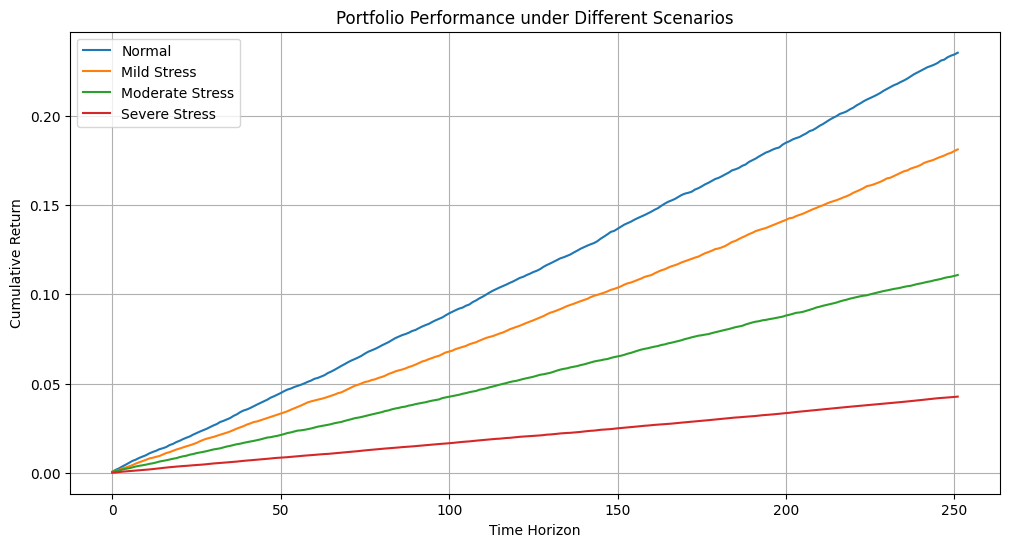


Portfolio Performance (based on historical data):
Expected Annual Return: 20.89%
Annual Volatility: 29.26%
Sharpe Ratio: 0.71


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

class PortfolioStressTester:
    def __init__(self, tickers, weights, initial_investment):
        self.tickers = tickers
        self.weights = weights
        self.initial_investment = initial_investment
        self.data = None
        self.returns = None
        self.cov_matrix = None

    def fetch_data(self, start_date, end_date):
        self.data = yf.download(self.tickers, start=start_date, end=end_date)['Adj Close']
        self.returns = self.data.pct_change().dropna()
        self.cov_matrix = self.returns.cov()

    def calculate_portfolio_performance(self, returns):
        portfolio_return = np.sum(returns.mean() * self.weights) * 252
        portfolio_volatility = np.sqrt(np.dot(self.weights.T, np.dot(returns.cov() * 252, self.weights)))
        sharpe_ratio = portfolio_return / portfolio_volatility
        return portfolio_return, portfolio_volatility, sharpe_ratio

    def simulate_normal_scenario(self, num_simulations, time_horizon):
        np.random.seed(42)
        simulated_returns = np.random.multivariate_normal(
            self.returns.mean().values,
            self.cov_matrix.values,
            (num_simulations, time_horizon)
        )
        # Reshape simulated_returns to 2D for dot product
        simulated_returns = simulated_returns.reshape(num_simulations * time_horizon, -1)
        portfolio_returns = np.dot(simulated_returns, self.weights)
        cumulative_returns = np.cumprod(1 + portfolio_returns.reshape(num_simulations, time_horizon), axis=1) - 1
        return cumulative_returns

    def simulate_stress_scenario(self, num_simulations, time_horizon, stress_factor):
        stressed_means = self.returns.mean() * stress_factor
        stressed_cov = self.cov_matrix * (stress_factor ** 2)
        simulated_returns = np.random.multivariate_normal(
            stressed_means.values,
            stressed_cov.values,
            (num_simulations, time_horizon)
        )
        # Reshape simulated_returns to 2D for dot product
        simulated_returns = simulated_returns.reshape(num_simulations * time_horizon, -1)
        portfolio_returns = np.dot(simulated_returns, self.weights)
        cumulative_returns = np.cumprod(1 + portfolio_returns.reshape(num_simulations, time_horizon), axis=1) - 1
        return cumulative_returns

    def calculate_var(self, returns, confidence_level):
        return np.percentile(returns, 100 - confidence_level)

    def calculate_cvar(self, returns, confidence_level):
        var = self.calculate_var(returns, confidence_level)
        return returns[returns <= var].mean()

    def run_stress_test(self, num_simulations, time_horizon, stress_scenarios):
        results = {}
        normal_scenario = self.simulate_normal_scenario(num_simulations, time_horizon)
        results['Normal'] = normal_scenario

        for scenario, stress_factor in stress_scenarios.items():
            stressed_scenario = self.simulate_stress_scenario(num_simulations, time_horizon, stress_factor)
            results[scenario] = stressed_scenario

        return results

    def analyze_results(self, results, confidence_level):
        analysis = {}
        for scenario, returns in results.items():
            final_returns = returns[:, -1]
            analysis[scenario] = {
                'Mean Return': np.mean(final_returns),
                'Volatility': np.std(final_returns),
                f'VaR ({confidence_level}%)': self.calculate_var(final_returns, confidence_level),
                f'CVaR ({confidence_level}%)': self.calculate_cvar(final_returns, confidence_level),
                'Max Drawdown': np.min(final_returns),
                'Max Return': np.max(final_returns)
            }
        return pd.DataFrame(analysis).T

    def plot_results(self, results):
        plt.figure(figsize=(12, 6))
        for scenario, returns in results.items():
            mean_returns = np.mean(returns, axis=0)
            plt.plot(mean_returns, label=scenario)
        plt.title('Portfolio Performance under Different Scenarios')
        plt.xlabel('Time Horizon')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True)
        plt.show()

def main():
    # Define portfolio
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
    weights = np.array([0.25, 0.25, 0.25, 0.25])  # Equal weights, corrected to 4 elements
    initial_investment = 100000

    # Initialize PortfolioStressTester
    stress_tester = PortfolioStressTester(tickers, weights, initial_investment)

    # Fetch historical data
    stress_tester.fetch_data('2018-01-01', '2023-01-01')

    # Define stress scenarios
    stress_scenarios = {
        'Mild Stress': 0.8,
        'Moderate Stress': 0.5,
        'Severe Stress': 0.2
    }

    # Run stress test
    num_simulations = 10000
    time_horizon = 252  # One year of trading days
    results = stress_tester.run_stress_test(num_simulations, time_horizon, stress_scenarios)

    # Analyze results
    confidence_level = 95
    analysis = stress_tester.analyze_results(results, confidence_level)
    print("Stress Test Analysis:")
    print(analysis)

    # Plot results
    stress_tester.plot_results(results)

    # Calculate and print portfolio performance
    portfolio_return, portfolio_volatility, sharpe_ratio = stress_tester.calculate_portfolio_performance(stress_tester.returns)
    print(f"\nPortfolio Performance (based on historical data):")
    print(f"Expected Annual Return: {portfolio_return:.2%}")
    print(f"Annual Volatility: {portfolio_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

if __name__ == "__main__":
    main()

This script does the following:

Defines a PortfolioStressTester class with methods for:

*   Fetching historical stock data
*   Calculating portfolio performance
*   Simulating normal and stress scenarios
*   Calculating Value at Risk (VaR) and Conditional Value at Risk (CVaR)
*   Running stress tests
*   Analyzing and plotting results


In the main() function:

*   Defines a sample portfolio with equal weights for five tech stocks
Fetches historical data for these stocks
*   Defines stress scenarios (mild, moderate, and severe stress)
*   Runs the stress test
*   Analyzes and prints the results
*   Plots the portfolio performance under different scenarios
*   Calculates and prints the portfolio's historical performance metrics



To run this script, you'll need to install the required libraries:
Copypip install numpy pandas yfinance matplotlib scipy
This implementation provides a comprehensive stress testing and scenario analysis framework. It allows you to:

Simulate normal market conditions and compare them with stressed scenarios.
Analyze the impact of different levels of market stress on your portfolio.
Calculate risk metrics like VaR and CVaR under different scenarios.
Visualize how your portfolio might perform under various market conditions.

Key points to note:

*   The stress scenarios are simulated by adjusting the mean returns and covariance matrix of the historical data.
*   The script uses Monte Carlo simulation to generate multiple possible future paths for the portfolio.
*   The analysis includes metrics like mean return, volatility, VaR, CVaR, maximum drawdown, and maximum return for each scenario.
*   The plot shows the mean cumulative return path for each scenario, allowing for visual comparison.

You can easily modify this script to include more assets, different weights, or additional stress scenarios. You can also extend it to include more sophisticated stress testing techniques or to analyze specific events or market shocks.